<a href="https://colab.research.google.com/github/robLaing2/Forex_ANN_Forecasting/blob/master/ForexAnnEnvironment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Environment

In [98]:
%tensorflow_version 2.x

!pip install quandl
!pip install dbnomics
#!pip install FRB
!pip install fred
!pip install mock
#!pip uninstall tensorflow
#!pip install tensorflow==2.0.0

import fred
from mock import Mock
import requests
import json
import quandl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, CuDNNLSTM
from dbnomics import fetch_series
import pandas as pd
from keras.models import model_from_json
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data Preparation

In [0]:
START_DATE = '2001-01-01'
END_DATE = '2020-02-01'

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


## Moving average function

In [0]:
def getMovingAverages(data, windowSize):

    movingAverages = []

    for x in range(len(data)):
        if (x < windowSize):
            window = data[:x+1]
        else:
            window = data[x-(windowSize - 1):x+1]
        
        total = sum(window)
        average = total / len(window)
        movingAverages.append(average)

    return movingAverages

## FOREX data

In [0]:
# Get FOREX data
quandl.ApiConfig.api_key = "VXqfuyrbTE8xxYZzqePw"
dataGbpEurRate = quandl.get("BOE/XUDLERS", start_date=START_DATE, end_date=END_DATE, returns="numpy")
forexDataN = dataGbpEurRate.Value

forexRaw = np.asarray(forexDataN)
forex_mean_raw = forexRaw.mean()
forex_std_raw = forexRaw.std()
forexRaw = (forexRaw - forex_mean_raw) / forex_std_raw

forexMonthMovAvg = getMovingAverages(forexDataN, 10)

forexMonthMovAvg = np.asarray(forexMonthMovAvg)
forex_mean_avg = forexMonthMovAvg.mean()
forex_std_avg = forexMonthMovAvg.std()
forexMonthMovAvg = (forexMonthMovAvg - forex_mean_avg) / forex_std_avg

ukFOREXdates = []
for x in dataGbpEurRate.Date:
    ukFOREXdates.append(pd.Timestamp(x))


forexData = {'Date':ukFOREXdates,'Value':forexMonthMovAvg}

forexRawDict = {ukFOREXdates[i]: forexRaw[i] for i in range(len(ukFOREXdates))}

mainDf = pd.DataFrame(forexData)

## Interest Rate Data (INT)


### INT data retreival

In [0]:
GBPovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBPONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
EURovr = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EURONTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
GBP1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
EUR1month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR1MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start=' + START_DATE + '&observation_end='+ END_DATE)
GBP3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR3month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR3MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
GBP6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR6month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR6MTD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
GBP12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=GBP12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)
EUR12month = requests.get('https://api.stlouisfed.org/fred/series/observations?series_id=EUR12MD156N&api_key=cdc4dd9f1b0596f6209a77cec5453528&file_type=json&observation_start='+ START_DATE + '&observation_end='+ END_DATE)

GBRovrJson = (json.loads(GBPovr.content))["observations"]
EURovrJson = (json.loads(EURovr.content))["observations"]
GBR1mJson = (json.loads(GBP1month.content))["observations"]
EUR1mJson = (json.loads(EUR1month.content))["observations"]
GBR3mJson = (json.loads(GBP3month.content))["observations"]
EUR3mJson = (json.loads(EUR3month.content))["observations"]
GBR6mJson = (json.loads(GBP6month.content))["observations"]
EUR6mJson = (json.loads(EUR6month.content))["observations"]
GBR12mJson = (json.loads(GBP12month.content))["observations"]
EUR12mJson = (json.loads(EUR12month.content))["observations"]

### INT data cleaning

In [0]:
def cleanDataSets(dataset):

    dataDict = {pd.Timestamp(dataset[i]["date"]): dataset[i]["value"] for i in range(len(dataset))}
    cleanedDataDict= {}
    count = 0

    for index, row in mainDf.iterrows():
        value = dataDict.get(row['Date'], 1000000)

        if (value=='.'):
            value = 1000000

        if(value==1000000):
            dateBelow = mainDf.Date.iloc[index-1]
            dateAbove = mainDf.Date.iloc[index+1]

            valueBelow = dataDict.get(dateBelow, 1000000)
            valueAbove = dataDict.get(dateAbove, 1000000)

            average = (float(valueBelow) + float(valueAbove)) / 2

            value = average

        cleanedDataDict[row['Date']] = value
        count = count + 1

    return cleanedDataDict

GBRovrC = cleanDataSets(GBRovrJson)
EURovrC = cleanDataSets(EURovrJson)
GBR3mC = cleanDataSets(GBR3mJson)
EUR3mC = cleanDataSets(EUR3mJson)
GBR6mC = cleanDataSets(GBR6mJson)
EUR6mC = cleanDataSets(EUR6mJson)
GBR12mC = cleanDataSets(GBR12mJson)
EUR12mC = cleanDataSets(EUR12mJson)

### INT feature engineering

In [0]:
def getDifferenceFeatures(xDict, yDict, avg):
    dates = []
    valuesX = []
    valuesY = []
    ratioValues = []                      

    for k,v in xDict.items():

        match = yDict.get(k, 0)
        valuesX.append(float(v))
        valuesY.append(float(match))
        dates.append(k)
 
    datasetXarr = np.array(valuesX, dtype=np.float)
    datasetYarr = np.array(valuesY, dtype=np.float)

    diffValues = datasetXarr - datasetYarr

    if(avg):
        diffValues = getMovingAverages(diffValues, 10)

    diffValues = np.asarray(diffValues)

    data_mean = diffValues.mean()
    data_std = diffValues.std()
    dataNormalised = (diffValues - data_mean) - data_std

    res = {dates[i]: dataNormalised[i] for i in range(len(dates))}

    return res

ovrRatio = getDifferenceFeatures(GBRovrC,EURovrC, False)
threeMRatio = getDifferenceFeatures(GBR3mC,EUR3mC, False)
sixMRatio = getDifferenceFeatures(GBR6mC,EUR6mC, False)
twelveMRatio = getDifferenceFeatures(GBR12mC,EUR12mC, False)

ovrRatioMovAvg = getDifferenceFeatures(GBRovrC,EURovrC, True)
threeMRatioMovAvg = getDifferenceFeatures(GBR3mC,EUR3mC, True)
sixMRatioMovAvg = getDifferenceFeatures(GBR6mC,EUR6mC, True)
twelveMRatioMovAvg = getDifferenceFeatures(GBR12mC,EUR12mC, True)

## Inflation data (CPI)

### CPI data retreival

In [0]:
ukCPI = fetch_series('IMF/CPI/M.GB.PCPIHA_PC_CP_A_PT')
euCPI = fetch_series('IMF/CPI/M.U2.PCPIHA_PC_CP_A_PT')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukCPI = ukCPI.query(dbnomicsQuery)
euCPI = euCPI.query(dbnomicsQuery)

ukCPIDict = {ukCPI.period.iloc[i]: ukCPI.value.iloc[i] for i in range(len(ukCPI))}
euCPIDict = {euCPI.period.iloc[i]: euCPI.value.iloc[i] for i in range(len(euCPI))}

### CPI data cleaning

In [106]:
def cleanMonthlyData(dataset):

    cleanedDataDict= {}
    count = 0
    clean=True

    for index, row in mainDf.iterrows():

        roundD = row['Date'].replace(day=1)

        value= dataset.get(pd.Timestamp(roundD),1000000)

        if(value==1000000):
            clean = False
            dateBelow = mainDf.Date.iloc[index-1]
            dateAbove = mainDf.Date.iloc[index+1]

            valueBelow = dataset.get(dateBelow, 1000000)
            valueAbove = dataset.get(dateAbove, 1000000)

            average = (float(valueBelow) + float(valueAbove)) / 2

            value = average

        cleanedDataDict[row['Date']] = value
        count = count + 1

    if(clean==True):
        print("Data is clean")

    return cleanedDataDict


ukCPIDictC = cleanMonthlyData(ukCPIDict)
euCPIDictC = cleanMonthlyData(euCPIDict)

Data is clean
Data is clean


### CPI feature engineering

In [0]:
dates = []
ukCPIarr = []
euCPIarr = []

for k,v in ukCPIDictC.items():

    match = euCPIDictC.get(k, 0)

    ukCPIarr.append(v)
    euCPIarr.append(match)
    dates.append(k)

ukCPIarr = np.array(ukCPIarr, dtype=np.float)
euCPIarr = np.array(euCPIarr, dtype=np.float)

ukEuCpiRatio = ukCPIarr - euCPIarr

# Normalise CPI data
cpi_mean = ukEuCpiRatio.mean()
cpi_std = ukEuCpiRatio.std()

ukEuCpiRatio = (ukEuCpiRatio - cpi_mean) / cpi_std

cpiDict = {dates[i]: ukEuCpiRatio[i] for i in range(len(dates))}

cpiData = {'Date':dates, 'Value':ukEuCpiRatio}
cpiDf = pd.DataFrame(cpiData)

## International Reserves data (IR)

### IR data retreival

In [0]:
ukIR = fetch_series('IMF/IFS/M.GB.RAFAGOLDM_USD')
euIR = fetch_series('IMF/IFS/M.U2.RAFAGOLDM_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukIR = ukIR.query(dbnomicsQuery)
euIR = euIR.query(dbnomicsQuery)

ukIRDict = {ukIR.period.iloc[i]: ukIR.value.iloc[i] for i in range(len(ukIR))}
euIRDict = {euIR.period.iloc[i]: euIR.value.iloc[i] for i in range(len(euIR))}

### IR data cleaning

In [109]:
ukIRDictC = cleanMonthlyData(ukIRDict)
euIRDictC = cleanMonthlyData(euIRDict)

Data is clean
Data is clean


### IR feature engineering

In [0]:
IRdates = []
ukIRarr = []
euIRarr = []

for k,v in ukIRDictC.items():

    match = euIRDictC.get(k, 0)

    ukIRarr.append(v)
    euIRarr.append(match)
    IRdates.append(k)


ukIRarr = np.array(ukIRarr, dtype=np.float)
euIRarr = np.array(euIRarr, dtype=np.float)

ukEuIRRatio = ukIRarr / euIRarr

ir_mean = ukEuIRRatio.mean()
ir_std = ukEuIRRatio.std()
ukEuIRRatio = (ukEuIRRatio - ir_mean) / ir_std

irDict = {IRdates[i]: ukEuIRRatio[i] for i in range(len(IRdates))}

irData = {'Date':IRdates, 'Value':ukEuIRRatio}
irDf = pd.DataFrame(irData)


## Balance of Payments data (BOP)

### BOP data retreival

In [0]:
ukBOP = fetch_series('IMF/BOP/Q.GB.BACK_BP6_USD')
euBOP = fetch_series('IMF/BOP/Q.U2.BACK_BP6_USD')

dbnomicsQuery = "period >= '" + START_DATE + "'"

ukBOP = ukBOP.query(dbnomicsQuery)
euBOP = euBOP.query(dbnomicsQuery)

ukBOPDict = {ukBOP.period.iloc[i]: ukBOP.value.iloc[i] for i in range(len(ukBOP))}
euBOPDict = {euBOP.period.iloc[i]: euBOP.value.iloc[i] for i in range(len(euBOP))}

### BOP data cleaning

In [112]:
def cleanQuarterlyData(dataset):

    cleanedDataDict= {}
    count = 0
    clean=True

    for index, row in mainDf.iterrows():

        date = row['Date']
        dateMonth = date.replace(day=1)
        dateQuarter = date.quarter
        
        switcher={
            1:date.replace(month=1,day=1),
            2:date.replace(month=4,day=1),
            3:date.replace(month=7,day=1),
            4:date.replace(month=10,day=1)
        }

        dateRoundedQuarter = switcher.get(dateQuarter)

        value = dataset.get(dateRoundedQuarter,1000000)

        if(value==1000000):
            mainDf.drop([index], inplace=True)
        else:
            cleanedDataDict[row['Date']] = value


    clean = True
    for k,v in cleanedDataDict.items():
        if (v==1000000):
            clean = False;

    if (clean==False):
        print("Data is unlcean")
    else:
        print("Data is clean")


    return cleanedDataDict


ukBOPDictC = cleanQuarterlyData(ukBOPDict)
euBOPDictC = cleanQuarterlyData(euBOPDict)

Data is clean
Data is clean


### BOP feature engineering

In [0]:
BOPdates = []
ukBOParr = []
euBOParr = []

for k,v in ukBOPDictC.items():

    match = euBOPDictC.get(k, 0)

    ukBOParr.append(v)
    euBOParr.append(match)
    BOPdates.append(k)

ukBOParr = np.array(ukBOParr, dtype=np.float)
euBOParr = np.array(euBOParr, dtype=np.float)

ukEuBOPRatio = ukBOParr / euBOParr

# Normalise BOP data
bop_mean = ukEuBOPRatio.mean()
bop_std = ukEuBOPRatio.std()
ukEuBOPRatio = (ukEuBOPRatio - bop_mean) / bop_std

bopDict = {BOPdates[i]: ukEuBOPRatio[i] for i in range(len(BOPdates))}

bopData = {'Date':BOPdates, 'Value':ukEuBOPRatio}
bopDf = pd.DataFrame(bopData)

## Creating full data matrix

In [114]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

completeDf = pd.DataFrame(columns=['Date','ForexAvg','ForexRaw','CPIRatio', 'IRRatio',
                                   'BOPRatio', 'OvrLIBOR','OvrAvg','3mLIBOR', '3mAvg',
                                   '6mLIBOR','6mAvg','12mLIBOR', '12mAvg'])

cpiCounter = 0
irCounter = 0
 
for index, row in mainDf.iterrows():

    date = row['Date']
    forex = row['Value']

    forexRaw = forexRawDict.get(date, 0)
    
    cpi = cpiDict.get(date, 0)
    ir = irDict.get(date,0)
    bop = bopDict.get(date,0)

    ovrI = ovrRatio.get(date, 0)
    ovrImov = ovrRatioMovAvg.get(date, 0)
    i3month = threeMRatio.get(date, 0)
    i3monthmov = threeMRatioMovAvg.get(date, 0)
    i6month = sixMRatio.get(date, 0)
    i6monthmov = sixMRatioMovAvg.get(date, 0)
    i12month = twelveMRatio.get(date, 0)
    i12monthmov = twelveMRatioMovAvg.get(date, 0)

    completeDf = completeDf.append({'Date':date,
                            'ForexAvg':forex,
                            'ForexRaw':forexRaw,
                            'CPIRatio': cpi,
                            'IRRatio' : ir,
                            'BOPRatio': bop,
                            'OvrLIBOR': ovrI,
                            'OvrAvg':ovrImov,
                            '3mLIBOR': i3month,
                            '3mAvg':i3monthmov,
                            '6mLIBOR': i6month,
                            '6mAvg':i6monthmov,
                            '12mLIBOR': i12month,
                            '12mAvg':i12monthmov},
                            ignore_index=True)

print(completeDf)

           Date  ForexAvg  ForexRaw  CPIRatio   IRRatio  BOPRatio  OvrLIBOR  \
0    2001-01-02  1.636760  1.638603 -1.445720  4.969333  0.295915 -0.772414   
1    2001-01-03  1.674689  1.714443 -1.445720  4.969333  0.295915 -0.477104   
2    2001-01-04  1.665890  1.650130 -1.445720  4.969333  0.295915 -0.993354   
3    2001-01-05  1.646925  1.591885 -1.445720  4.969333  0.295915 -1.143974   
4    2001-01-08  1.643678  1.632535 -1.445720  4.969333  0.295915 -1.018354   
...         ...       ...       ...       ...       ...       ...       ...   
4734 2019-09-24 -1.097566 -1.055864  0.563933  0.376361  0.144160 -0.502294   
4735 2019-09-25 -1.093258 -1.087414  0.563933  0.376361  0.144160 -0.488964   
4736 2019-09-26 -1.087432 -1.100155  0.563933  0.376361  0.144160 -0.497724   
4737 2019-09-27 -1.087371 -1.118357  0.563933  0.376361  0.144160 -0.503184   
4738 2019-09-30 -1.086885 -1.083167  0.563933  0.376361  0.144160 -0.502714   

        OvrAvg   3mLIBOR     3mAvg   6mLIBOR     6m

# Variable Correlation

In [0]:
variables = ['CPIRatio', 'IRRatio', 'BOPRatio', 'OvrLIBOR','3mLIBOR','6mLIBOR','12mLIBOR']

forex = completeDf['ForexAvg'].tolist()
correlations = []

for x in range(len(variables)):
    
    column = completeDf[variables[x]].tolist()

    r = np.corrcoef(forex, column)

    correlations.append(r[0,1])

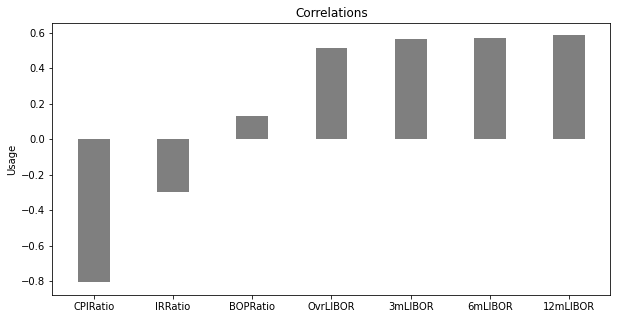

In [116]:
y_pos = np.arange(0,14,2)
plt.figure(figsize=(10,5))
plt.bar(y_pos, correlations, align='center', alpha=0.5, color=(0.0, 0.0, 0.0, 1))
plt.xticks(y_pos, variables)
plt.ylabel('Usage')
plt.title('Correlations')

plt.show()

# Neural Networks

## Data setup

In [117]:
import math

EPOCHS = 10
#EVALUATION_INTERVAL = 16
VALIDATION_STEPS = 50
BATCH_SIZE = 30
FOLDS = 5

HISTORY_STEPS = 6
FUTURE_STEPS = 6

target = ['ForexAvg']
features = ['ForexAvg']

dataSet = completeDf[features]
dataSet = dataSet.values

target = completeDf[target]
target = target.values


fold_steps = math.floor(len(dataSet) / FOLDS)
fold_locations = []
results = []

print(fold_steps)

for x in range(0,len(dataSet), fold_steps):
    fold_locations.append(x)

947


## Data splitting functions

In [0]:
def getIndices(currentIndex, steps):

    indices = []

    index = currentIndex

    for i in range(1, steps + 1):
        if i % 4 == 0:
            indices.append(index)
            index = index - 21
        else:
            indices.append(index)
            index = index - 22

    indices = list(reversed(indices))

    return indices


def singleStepDataSplit(dataset, target, startIndex, endIndex,
                steps, future_steps):  
    data = []
    labels = []

    history_size = 22 * steps

    max_index = 22 * future_steps
    target_size = round(21.75 * future_steps)

    startIndex = startIndex + history_size

    if endIndex is None:
        endIndex = len(dataset) - max_index

    for i in range(startIndex, endIndex):
        dataIndices = getIndices(i,steps)
        data.append(dataset[dataIndices])
        labels.append(target[i+target_size])

    return np.array(data), np.array(labels)

def getFutureIndices(currentIndex, steps):

    indices = []

    index = currentIndex + 22

    for i in range(1, steps + 1):
        if i % 4 == 0:
            indices.append(index)
            index = index + 21
        else:
            indices.append(index)
            index = index + 22

    return indices


def splitData(dataset, target, start_index, end_index, steps, future_steps):
    data = []
    labels = []

    history_size = 22 * steps
    target_size = 22 * future_steps

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = getIndices(i,steps)
        data.append(dataset[indices])
        indiciesL = getFutureIndices(i, future_steps)
        labels.append(target[indiciesL])

    return np.array(data), np.array(labels)

## Single-step LSTM

### Building network

In [0]:
def singleStepLSTM():
    singleStepLSTMModel = keras.Sequential([
        layers.LSTM(32, input_shape=(HISTORY_STEPS, len(features))),
        layers.Dense(1)
    ])

    singleStepLSTMModel.compile(optimizer='adam', loss='mse')
    return singleStepLSTMModel

### Training models

In [120]:
dataVal = []

def trainModel(history_steps, future_step):

    models = []
    results = []

    for x in range(1, FOLDS):

        model = singleStepLSTM()

        valIndex = fold_locations[x]
        
        if (x==FOLDS-1):
            endIndex = None
        else:
            endIndex = fold_locations[x+1]

        xTrain, yTrain = singleStepDataSplit(dataSet, target, 0, valIndex, history_steps, future_step)
        xVal, yVal = singleStepDataSplit(dataSet, target, valIndex, endIndex, history_steps, future_step)


        dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
        dataTrain = dataTrain.cache().batch(BATCH_SIZE).repeat()

        dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
        dataVal = dataVal.batch(BATCH_SIZE).repeat()

        print("--------------------- Model validated on fold ", "%d/%d --------------------------" % (x, FOLDS - 1))

        steps_per = math.floor(len(xTrain)/BATCH_SIZE)
        print(steps_per)

        result = model.fit(dataTrain, epochs=EPOCHS, steps_per_epoch=steps_per,
                            validation_data=dataVal, validation_steps=50)
        
        models.append(model)
        results.append(result)

    return models


def createModelsForAllSteps():

    allModels = []

    for i in range(1,FUTURE_STEPS+1):

        print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& Month", "%d/%d &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&" % (i, FUTURE_STEPS))

        models = trainModel(HISTORY_STEPS, i)
        allModels.append(models)


    return allModels

allModels = createModelsForAllSteps()

&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& Month 1/6 &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
--------------------- Model validated on fold  1/4 --------------------------
27
Epoch 1/10
27/27 [==============================] - 1s 20ms/step - loss: 1.5623 - val_loss: 0.2070
Epoch 2/10
27/27 [==============================] - 0s 6ms/step - loss: 0.2710 - val_loss: 0.0966
Epoch 3/10
27/27 [==============================] - 0s 6ms/step - loss: 0.0896 - val_loss: 0.0665
Epoch 4/10
27/27 [==============================] - 0s 7ms/step - loss: 0.0958 - val_loss: 0.0677
Epoch 5/10
27/27 [==============================] - 0s 7ms/step - loss: 0.0856 - val_loss: 0.0640
Epoch 6/10
27/27 [==============================] - 0s 6ms/step - loss: 0.0835 - val_loss: 0.0626
Epoch 7/10
27/27 [==============================] - 0s 6ms/step - loss: 0.0808 - val_loss: 0.0612
Epoch 8/10
27/27 [==============================] - 0s 6ms/step - loss: 0.0812 - val_loss: 0.0604
Epoch 9/10
27/27 [==============================] - 0s 6

### Single-step tests

In [121]:
allMses = []
allClassifications = []
bestGuessClassifications = []
relaxedGuessClassifications = []

def singleStepModelTests(model, xTest, yTest):

    mses = []
    classifications = []

    correctDirection = 0

    noDatapoints = len(xTest)
    print(noDatapoints)

    noPredictions = 6

    mse = model.evaluate(xTest,yTest)

    for x in range(noDatapoints):

        current = xTest[x][-1][0]
        past = tf.constant([xTest[x]])
        prediction = model.predict(past)[0]
        future = yTest[x]

        if((current > prediction) == (current > future)):
                correctDirection = correctDirection + 1

    #print("-------------------------------")
    #print("MSE: " + str(round(mse,3)))
    directionClass = correctDirection / noDatapoints
    #print("Direction classification: " + str(round(directionClass,3)))
    #print("-------------------------------")

    mses.append(mse)
    classifications.append(directionClass)

    return mses, classifications


def runModels(models):

    modelMses = []
    modelClassifications = []

    for i in range(1, FOLDS):

        print("running test")

        valIndex = fold_locations[i]
    
        if (i==FOLDS-1):
            endIndex = None
        else:
            endIndex = fold_locations[i+1]

        xTest, yTest = singleStepDataSplit(dataSet, dataSet[:, 0], valIndex, endIndex, HISTORY_STEPS, FUTURE_STEPS)

        mses,classifications = singleStepModelTests(models[i-1], xTest, yTest)

        modelMses.append(mses)
        modelClassifications.append(classifications)

        meanMse = np.mean(modelMses)
        meanClass = np.mean(modelClassifications)
    
    #print("-------------------------------------------------------------")
    #print("Average MSE: " + str(meanMse))
    #print("Average classification: " + str(np.mean(classifications)))
    #print("-------------------------------------------------------------")

    return modelMses, modelClassifications


def bestGuessTests(models, fold):

    valIndex = fold_locations[fold+1]
    
    if (fold==FOLDS-2):
        endIndex = None
    else:
        endIndex = fold_locations[fold+2]

    print(valIndex)
    print(endIndex)

    correctMax = 0
    correctMaxRelaxed = 0

    xTest, yTest = splitData(dataSet, dataSet[:, 0], valIndex, endIndex, HISTORY_STEPS, FUTURE_STEPS)

    for datapoint in range(len(xTest)):

        past = tf.constant([xTest[datapoint]])
        future = yTest[datapoint]

        predictions = []

        for j in range(FUTURE_STEPS):

            prediction = models[j].predict(past)
            predictions.append(prediction)

        actualMax = np.argmax(future)
        predictedMax = np.argmax(predictions)

        future[actualMax] = -100000
        actual2ndMax = np.argmax(future)

        if(predictedMax == actualMax):
            correctMax = correctMax + 1
            correctMaxRelaxed = correctMaxRelaxed + 1
        elif(predictedMax == actual2ndMax):
            correctMaxRelaxed = correctMaxRelaxed + 1
    
    print("--------------------------------")
            


    #print("---------------")
    bestMonthClass = correctMax / len(xTest)
    bestMonthRelaxedClass = correctMaxRelaxed / len(xTest)

    #print("Correct best month: " + str(round(bestMonthClass,3)))

    print("------------")
    print(correctMax)
    print(bestMonthRelaxedClass)

    return bestMonthClass, bestMonthRelaxedClass

def runBestGuessTests(allModels):

    foldPerformances = []
    relaxedFoldperformances = []

    for i in range(len(allModels[0])):

        print("running best guess test")

        foldModels = []

        for j in range(FUTURE_STEPS):
            foldModels.append(allModels[j][i])

        foldPerformance, relaxedFoldperformance = bestGuessTests(foldModels, i)

        foldPerformances.append(foldPerformance)
        relaxedFoldperformances.append(relaxedFoldperformance)

    return foldPerformances, relaxedFoldperformances


def singleStepExperiments():
    
    print("MODELS CREATED")

    for modelsForOneStep in allModels:
        print("MODEL STEP TESTS")

        modelMses, modelClassifications = runModels(modelsForOneStep)
        allMses.append(modelMses)
        allClassifications.append(modelClassifications)

    print("MODEL STEP TESTS COMPLETE")
    print("TESTING BEST GUESS ABILITY")

    bestGuess, relaxedGuess = runBestGuessTests(allModels)

    bestGuessClassifications.append(bestGuess)
    relaxedGuessClassifications.append(relaxedGuess)


    print("TESTING COMPLETE")

singleStepExperiments()



MODELS CREATED
MODEL STEP TESTS
running test
815
26/26 [==============================] - 0s 2ms/step - loss: 0.3757
running test
815
26/26 [==============================] - 0s 2ms/step - loss: 0.1708
running test
815
26/26 [==============================] - 0s 2ms/step - loss: 0.2844
running test
687
22/22 [==============================] - 0s 2ms/step - loss: 0.0517
MODEL STEP TESTS
running test
815
26/26 [==============================] - 0s 2ms/step - loss: 0.3736
running test
815
26/26 [==============================] - 0s 2ms/step - loss: 0.2701
running test
815
26/26 [==============================] - 0s 2ms/step - loss: 0.3036
running test
687
22/22 [==============================] - 0s 2ms/step - loss: 0.0557
MODEL STEP TESTS
running test
815
26/26 [==============================] - 0s 2ms/step - loss: 0.3997
running test
815
26/26 [==============================] - 0s 2ms/step - loss: 0.2034
running test
815
26/26 [==============================] - 0s 2ms/step - loss: 0.3042

In [122]:
print(allMses)                      #shape = FUTURE_STEPS, FOLDS
print(allClassifications)           #shape = FUTURE_STEPS, FOLDS
print(bestGuessClassifications)      #shape = FOLDS
print(relaxedGuessClassifications)   #shape = FOLDS

[[[0.37574145197868347], [0.17078211903572083], [0.28442180156707764], [0.05168940871953964]], [[0.37362560629844666], [0.2701045870780945], [0.30362141132354736], [0.05568969249725342]], [[0.3996758759021759], [0.20336085557937622], [0.30416470766067505], [0.0606694333255291]], [[0.39340466260910034], [0.22506402432918549], [0.28473907709121704], [0.07402651011943817]], [[0.3317168056964874], [0.3981090188026428], [0.3232356607913971], [0.08182618767023087]], [[0.37357091903686523], [0.23133672773838043], [0.2844029664993286], [0.09411440044641495]]]
[[[0.5226993865030675], [0.5803680981595092], [0.39754601226993863], [0.5385735080058224]], [[0.5312883435582823], [0.5803680981595092], [0.4049079754601227], [0.5109170305676856]], [[0.5435582822085889], [0.5803680981595092], [0.40736196319018403], [0.49199417758369723]], [[0.5447852760736196], [0.5803680981595092], [0.41226993865030676], [0.4570596797671033]], [[0.5791411042944785], [0.5803680981595092], [0.4134969325153374], [0.4512372

In [123]:
print(allMses[0])

print(bestGuessClassifications[0])

[[0.37574145197868347], [0.17078211903572083], [0.28442180156707764], [0.05168940871953964]]
[0.27975460122699386, 0.19631901840490798, 0.38404907975460123, 0.1717612809315866]


### Results

In [0]:
def printResults(mses,directionClass,bestClass):

    for i in range(FUTURE_STEPS):

        print("-----------")
        print("Month " + str((i+1)))
        print("MSE: " + str(mses[i]))
        print("Dir: " + str(directionClass[i]))

    print("---------")
    print("Bes: " + str(bestClass))

#printResults(allMses, allClassifications, bestClass)

### Prediction visualisation

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def create_time_steps(length,steps):
    return list(np.arange(-length, 0,step=steps))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(TIME_LAGS,STEP)

    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


#for x, y in dataVal.take(1):
#    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
#                        model.predict(x)[0]], PREDICTION_HORIZON,
#                    'Single Step Prediction')
#    print(model.predict(x)[0])
#    plot.show()

## Multi-step LSTM

### Building network

In [0]:
def multiStepLSTM():
    multiStepLSTMModel = keras.Sequential([
        layers.LSTM(units=32, return_sequences=True, input_shape = (HISTORY_STEPS, len(features))),
        layers.LSTM(16, activation='relu'),
        layers.Dense(FUTURE_STEPS)
    ])

    multiStepLSTMModel.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')
    return multiStepLSTMModel

multiStepModel = multiStepLSTM()

### Training models

In [127]:
models = []
results = []
dataTrainMulti = []

for x in range(1, FOLDS):

    valIndex = fold_locations[x]

    multiStepModel = multiStepLSTM()
    
    if (x==FOLDS-1):
        endIndex = None
    else:
        endIndex = fold_locations[x+1]

    xTrainMulti, yTrainMulti = splitData(dataSet, target, 0, valIndex, HISTORY_STEPS, FUTURE_STEPS)
    xValMulti, yValMulti = splitData(dataSet, target, valIndex, None, HISTORY_STEPS, FUTURE_STEPS)

    dataTrainMulti = tf.data.Dataset.from_tensor_slices((xTrainMulti, yTrainMulti))
    dataTrainMulti = dataTrainMulti.cache().batch(BATCH_SIZE).repeat()

    dataValMulti = tf.data.Dataset.from_tensor_slices((xValMulti, yValMulti))
    dataValMulti = dataValMulti.batch(BATCH_SIZE).repeat()

    print("--------------------- Model", "%d/%d --------------------------" % (x, FOLDS - 1))

    steps_per = math.floor(len(xTrainMulti)/BATCH_SIZE)
    print(steps_per)

    result = multiStepModel.fit(dataTrainMulti, epochs=EPOCHS, steps_per_epoch=steps_per,
                        validation_data=dataValMulti, validation_steps=50)
    
    models.append(multiStepModel)
    results.append(result)

--------------------- Model 1/4 --------------------------
27
Epoch 1/10
27/27 [==============================] - 1s 26ms/step - loss: 1.3409 - val_loss: 0.6527
Epoch 2/10
27/27 [==============================] - 0s 9ms/step - loss: 0.2690 - val_loss: 0.6033
Epoch 3/10
27/27 [==============================] - 0s 10ms/step - loss: 0.0857 - val_loss: 0.6364
Epoch 4/10
27/27 [==============================] - 0s 10ms/step - loss: 0.0839 - val_loss: 0.6509
Epoch 5/10
27/27 [==============================] - 0s 9ms/step - loss: 0.0822 - val_loss: 0.6490
Epoch 6/10
27/27 [==============================] - 0s 9ms/step - loss: 0.0788 - val_loss: 0.6434
Epoch 7/10
27/27 [==============================] - 0s 9ms/step - loss: 0.0768 - val_loss: 0.6415
Epoch 8/10
27/27 [==============================] - 0s 9ms/step - loss: 0.0780 - val_loss: 0.6442
Epoch 9/10
27/27 [==============================] - 0s 9ms/step - loss: 0.0801 - val_loss: 0.6490
Epoch 10/10
27/27 [==============================] - 

### Multi-step tests

In [0]:
allMsesMulti = []
allClassificationsMulti = []
bestGuessClassificationsMulti = []
relaxedGuessClassificationsMulti = []

def multiStepModelTests(model, xTest, yTest):

    correctDirection = [0,0,0,0,0,0]
    totalSquaredError = [0,0,0,0,0,0]
    correctMax = 0
    correctMaxRelaxed = 0

    noDatapoints = len(xTest)
    noPredictions = len(totalSquaredError)

    for x in range(noDatapoints):
        current = xTest[x][-1][0]
        past = tf.constant([xTest[x]])
        predictions = model.predict(past)[0]
        future = yTest[x]

        predictedMax = np.argmax(predictions)
        actualMax = np.argmax(future)

        temp = future[actualMax]
        future[actualMax] = -100000
        actual2ndMax = np.argmax(future)

        if(predictedMax == actualMax):
            correctMax = correctMax + 1
            correctMaxRelaxed = correctMaxRelaxed + 1
        elif(predictedMax == actual2ndMax):
            correctMaxRelaxed = correctMaxRelaxed + 1

        future[actualMax]=temp

        for y in range(noPredictions):
            prediction = predictions[y]
            actual = future[y]

            squaredDifference = abs(prediction - actual) ** 2
            totalSquaredError[y] = totalSquaredError[y] + squaredDifference

            if ((current > prediction) == (current > actual)):
                correctDirection[y] = correctDirection[y] + 1


    mses = []
    classifications = []

    for x in range(noPredictions):
        mse = totalSquaredError[x] / noDatapoints
        mses.append(mse)

    for x in range(noPredictions):
        percentInterval = correctDirection[x] / noDatapoints
        classifications.append(percentInterval)

    bestMonthClass = correctMax / noDatapoints
    bestMonthRelaxedClass = correctMaxRelaxed / noDatapoints

    allMsesMulti.append(mses)
    allClassificationsMulti.append(classifications)
    bestGuessClassificationsMulti.append(bestMonthClass)
    relaxedGuessClassificationsMulti.append(bestMonthRelaxedClass)


def runModels(models):

    modelMses = []
    modelClassifications = []

    for i in range(1, FOLDS):

        valIndex = fold_locations[i]
    
        if (i==FOLDS-1):
            endIndex = None
        else:
            endIndex = fold_locations[i+1]

        xTestMulti, yTestMulti = splitData(dataSet, dataSet[:, 0], valIndex, endIndex, HISTORY_STEPS, FUTURE_STEPS)

        multiStepModelTests(models[i-1], xTestMulti, yTestMulti)

runModels(models)

In [129]:
allMsesMulti = list(map(list, zip(*allMsesMulti)))
allClassificationsMulti = list(map(list, zip(*allClassificationsMulti)))

print(allMsesMulti)
print(allClassificationsMulti)
print(bestGuessClassificationsMulti)
print(relaxedGuessClassificationsMulti)

[[0.1317547737764125, 0.8228568941894123, 0.3814350659204064, 0.4080429215100614], [0.16915026160426602, 0.929306287712178, 0.3654188448295189, 0.7049553403983151], [0.18338584934600452, 0.9011635310950867, 0.5125760806423945, 0.7607118689400008], [0.2282895195661945, 0.9739380055559929, 0.46335026081392494, 0.6751744026754343], [0.25467822233151655, 0.7438374291282924, 0.5054446369340408, 0.9081553380133742], [0.3198712218655316, 0.6795721759678822, 0.6725066499939667, 0.9630535477904828]]
[[0.4699386503067485, 0.5840490797546012, 0.4429447852760736, 0.46142649199417757], [0.49079754601226994, 0.5815950920245399, 0.3815950920245399, 0.48180494905385735], [0.4588957055214724, 0.6613496932515337, 0.32883435582822085, 0.519650655021834], [0.5190184049079755, 0.6539877300613497, 0.36319018404907977, 0.5065502183406113], [0.554601226993865, 0.6257668711656442, 0.35337423312883437, 0.46142649199417757], [0.550920245398773, 0.5803680981595092, 0.3239263803680982, 0.4279475982532751]]
[0.3742

### Results

In [0]:
def printResults(monthAverageMses,monthAverageClass,bestClass):

    for i in range(len(monthAverageMses)):

        print("-----------")
        print("Month " + str((i+1)))
        print("MSE: " + str(monthAverageMses[i]))
        print("Dir: " + str(monthAverageClass[i]))

    print("---------")
    print("Bes: " + str(bestClass))

#printResults(monthAverageMses, monthAverageClass, bestClass)

### Prediction visualisation

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(TIME_LAGS,STEP)
  num_out = len(true_future) * FUTURE_STEP

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out, step=FUTURE_STEP), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out,step=FUTURE_STEP), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

#model = models[-1]

#for x, y in dataTrainMulti.take(1):
#
#    print(x)

    #print((multiStepModel.predict(x)[0]).index(max(multiStepModel.predict(x)[0])))
#    print(model.predict(x)[0])
#    multi_step_plot(x[0], y[0], model.predict(x)[0])


# Exporting Results

In [0]:
!pip install --upgrade -q pygsheets

import google.auth
from google.colab import auth

auth.authenticate_user()
import pygsheets
credentials, _ = google.auth.default()
gc = pygsheets.client.Client(credentials)

gc.create(title="ExperimentResultsforex6",folder="1zb8cLLf2RtYz9RuofDhGDgmTAoXD2VnE")

sh = gc.open('ExperimentResultsforex6')

#sh.add_worksheet('OvrLibor') 

wk1 = sh[0]

titles = ['SINGLE_STEP','MSE(Fold1)','MSE(Fold2)','MSE(Fold3)','MSE(Fold4)','MSE(avg)',
          'Dir(Fold1)','Dir(Fold2)','Dir(Fold3)','Dir(Fold4)','Dir(avg)']

shiftSize = FUTURE_STEPS + 5

wk1.insert_rows(row = 0, number = 0, values = titles) # insert 1 new row and insert values in same row

mseAvgsSingle = []
dirAvgsSingle = []
bestSingle = []
relaxedSingle = []

mseAvgsMulti = []
dirAvgsMulti = []
bestMulti = []
relaxedMultti = []

for step in range(FUTURE_STEPS):

    row = []

    month = 'Month ' + str(step+1)

    row.append(month)
    
    for fold in range(FOLDS-1):
        row.append(str(allMses[step][fold][0]))

    arr = np.asarray(allMses[step])
    mean = np.mean(arr)
    row.append(mean)
    mseAvgsSingle.append(mean)

    for fold in range(FOLDS-1):
        row.append(str(allClassifications[step][fold][0]))

    arr = np.asarray(allClassifications[step])
    mean = np.mean(arr)
    row.append(str(mean))
    dirAvgsSingle.append(mean)

    wk1.insert_rows(row = step+1, number = 1, values = row)

guessTitles = ['','Best(Fold1)','Best(Fold2)','Best(Fold3)','Best(Fold4)','Best(avg)',
               'Relaxed(Fold1)','Relaxed(Fold2)','Relaxed(Fold3)','Relaxed(Fold4)','Relaxed(avg)']

wk1.insert_rows(row = FUTURE_STEPS+2, number = 1, values = guessTitles)

guessResults = ['']

for fold in range(len(bestGuessClassificationsMulti)):
    classification = bestGuessClassifications[0][fold]
    guessResults.append(classification)

arr = np.asarray(bestGuessClassifications[0])
mean = np.mean(arr)
guessResults.append(str(mean))
bestSingle = mean

for fold in range(len(bestGuessClassificationsMulti)):
    classification = relaxedGuessClassifications[0][fold]
    guessResults.append(classification)

arr = np.asarray(relaxedGuessClassifications[0])
mean = np.mean(arr)
guessResults.append(str(mean))
relaxedSingle = mean

wk1.insert_rows(row = FUTURE_STEPS+3, number = 1, values = guessResults)


titles[0] = 'MULTI-STEP'

wk1.insert_rows(row = shiftSize, number = 0, values = titles) # insert 1 new row and insert values in same row

for step in range(FUTURE_STEPS):

    row = []

    month = 'Month ' + str(step+1)

    row.append(month)
    
    for fold in range(FOLDS-1):
        row.append(str(allMsesMulti[step][fold]))

    arr = np.asarray(allMsesMulti[step])
    mean = np.mean(arr)
    row.append(mean)
    mseAvgsMulti.append(mean)

    for fold in range(FOLDS-1):
        row.append(str(allClassificationsMulti[step][fold]))

    arr = np.asarray(allClassificationsMulti[step])
    mean = np.mean(arr)
    row.append(str(mean))
    dirAvgsMulti.append(mean)

    wk1.insert_rows(row = shiftSize+step+1, number = 1, values = row)

guessTitles = ['','Best(Fold1)','Best(Fold2)','Best(Fold3)','Best(Fold4)','Best(avg)',
               'Relaxed(Fold1)','Relaxed(Fold2)','Relaxed(Fold3)','Relaxed(Fold4)','Relaxed(avg)']

wk1.insert_rows(row = shiftSize+FUTURE_STEPS+2, number = 1, values = guessTitles)

guessResults = ['']

for fold in range(len(bestGuessClassificationsMulti)):
    classification = bestGuessClassificationsMulti[fold]
    guessResults.append(classification)

arr = np.asarray(bestGuessClassificationsMulti)
mean = np.mean(arr)
guessResults.append(str(mean))
bestMulti = mean

for fold in range(len(bestGuessClassificationsMulti)):
    classification = relaxedGuessClassificationsMulti[fold]
    guessResults.append(classification)

arr = np.asarray(relaxedGuessClassificationsMulti)
mean = np.mean(arr)
guessResults.append(str(mean))
relaxedMulti = mean

wk1.insert_rows(row = shiftSize+FUTURE_STEPS+3, number = 1, values = guessResults)

for i in range(FUTURE_STEPS):

    month = 'Month ' + str(i+1)
    row = [month]
    row.append(str(mseAvgsSingle[i]))
    row.append(str(dirAvgsSingle[i]))
    row.append(str(mseAvgsMulti[i]))
    row.append(str(dirAvgsMulti[i]))

    wk1.insert_rows(row = shiftSize+FUTURE_STEPS+i+7, number = 1, values = row)

row = ['Guesses']
row.append(str(bestSingle))
row.append(str(relaxedSingle))
row.append(str(bestMulti))
row.append(str(relaxedMulti))

wk1.insert_rows(row = shiftSize+FUTURE_STEPS+FUTURE_STEPS+7, number = 1, values = row)

# Visualising Results


## Importing Results

In [133]:
!pip install --upgrade -q pygsheets

import google.auth
from google.colab import auth
import pygsheets
import matplotlib as mpl
import matplotlib.pyplot as plt

msesSingleAll = []
msesMultiAll = []
dirSingleAll = []
dirMultiAll = []
bestGuessSingle = []
bestGuessMulti = []
relaxedGuessSingle = []
relaxedGuessMulti = []

worksheetIndices = [1,2,3,4,6,8,10,12]

def importWorksheet(index):

    auth.authenticate_user()
    credentials, _ = google.auth.default()
    gc = pygsheets.client.Client(credentials)

    #gc.create(title="ExperimentResultsforexraw",folder="1wdAbtGXmMA8xbW_ItVbXASyfhVUmyV8a")

    sh = gc.open('Copy of ExperimentResultsF')

    wk1 = sh[index]

    summaryRow = 25

    msesSingle = []
    msesMulti = []
    dirSingle = []
    dirMulti = []
    guesses = []

    for i in range(6):

        row = wk1.get_row(summaryRow)

        msesSingle.append(float(row[1]))
        msesMulti.append(float(row[3]))
        dirSingle.append(float(row[2]))
        dirMulti.append(float(row[4]))

        summaryRow = summaryRow + 1

    guesses = wk1.get_row(summaryRow)

    bestGuessSingle.append(float(guesses[1]))
    bestGuessMulti.append(float(guesses[3]))
    relaxedGuessSingle.append(float(guesses[2]))
    relaxedGuessMulti.append(float(guesses[4]))

    msesSingleAll.append(msesSingle)
    msesMultiAll.append(msesMulti)
    dirSingleAll.append(dirSingle)
    dirMultiAll.append(dirMulti)


def importAllWorksheets():

    for index in worksheetIndices:

        importWorksheet(index)


importAllWorksheets()

#monthGraph(msesSingleAll,'Months','MSE','MSE Single-step')
#monthGraph(msesMultiAll,'Months','MSE','MSE Multi-step')
#monthGraph(dirSingleAll,'Months','Classification','Classification Single-step')
#monthGraph(dirMultiAll,'Months','Classification','Classification Multi-step')



#plt.savefig('foo.png')
#plt.show()

KeyboardInterrupt: ignored

## Create Graphs

In [0]:

titles = ['Forex','CPI','IR','BOP','OVR','3m','6m','12m']
months = [1,2,3,4,5,6]


def monthGraph(data, xLabel, yLabel, title):

    x = months

    for i in range(len(data)):

        y1 = data[i]
        
        plt.plot(x, y1, label = titles[i])

    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.legend()
    plt.show()

def guessBarChart(data1, data2, title, threshold):

    x = np.arange(len(titles))
    width = 0.35 

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, data1, width, label='Single-Step')
    rects2 = ax.bar(x + width/2, data2, width, label='Multi-step')
    ax.plot([-0.35, 7.35], [threshold, threshold], "k--")
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Classification')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(titles)
    ax.legend()


monthGraph(msesSingleAll,'Months','MSE','MSE Single-step')
monthGraph(msesMultiAll,'Months','MSE','MSE Multi-step')
monthGraph(dirSingleAll,'Months','Classification','Classification Single-step')
monthGraph(dirMultiAll,'Months','Classification','Classification Multi-step')

guessBarChart(bestGuessSingle, bestGuessMulti, 'Best Guess Classification', (1/6))
guessBarChart(relaxedGuessSingle, relaxedGuessMulti, 'Relaxed Guess Classification', (1/3))

# ARIMA


In [0]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

xValues, yValues = splitData(dataSet, target, 3500, None, 40, FUTURE_STEPS)

mses = []

def mseARIMAmodel(p,q,d):

    print("new")

    tmse = 0

    for x in range(len(xValues)):
        current = xValues[x][-1][0]
        past = xValues[x]
        future = yValues[x]

        print(future)

        model = ARIMA(past, order=(p,q,d))
        model_fit = model.fit(disp=0)
        predictions = model_fit.forecast(steps=FUTURE_STEPS)[0]

        error = mean_squared_error(future,predictions)
        tmse = tmse + error

    mse = tmse / len(xValues)
    print("For paramters: " + str(p) + str(q) + str(d))
    print("MSE: " + str(mse))
    mses.append(mse)


def tuneParamters():
    p_values = [4, 6, 8, 10]
    d = 1
    q = 0

    for p in p_values:
        mseARIMAmodel(p,d,q)


tuneParamters()
    

In [0]:
arimaMSES = []
arimaDir = []
arimaBestGuess = []
arimaRelaxedGuess = []

xValues, yValues = splitData(dataSet, target, 950, None, 40, FUTURE_STEPS)

def testARIMA():

    correctDirection = [0,0,0,0,0,0]
    totalSquaredError = [0,0,0,0,0,0]
    correctMax = 0
    correctMaxRelaxed = 0

    for x in range(len(xValues)):
        print(x)
        current = xValues[x][-1][0]
        past = xValues[x]
        future = yValues[x]

        model = ARIMA(past, order=(6,1,0))
        model_fit = model.fit(disp=0)
        predictions = model_fit.forecast(steps=FUTURE_STEPS)[0]

        predictedMax = np.argmax(predictions)
        actualMax = np.argmax(future)

        temp = future[actualMax][0]
        future[actualMax] = -100000
        actual2ndMax = np.argmax(future)

        print(future)

        if(predictedMax == actualMax):
            correctMax = correctMax + 1
            correctMaxRelaxed = correctMaxRelaxed + 1
        elif(predictedMax == actual2ndMax):
            correctMaxRelaxed = correctMaxRelaxed + 1

        print(temp)
        future[actualMax]=temp

        print(future)
        

        for y in range(FUTURE_STEPS):
            prediction = predictions[y]
            actual = future[y]

            print(prediction)
            print(actual)

            squaredDifference = abs(prediction - actual) ** 2

            print(squaredDifference)
            totalSquaredError[y] = totalSquaredError[y] + squaredDifference


            if ((current > prediction) == (current > actual)):
                correctDirection[y] = correctDirection[y] + 1



    mses = []
    classifications = []

    for x in range(FUTURE_STEPS):
        mse = totalSquaredError[x] / len(xValues)
        arimaMSES.append(mse)

    for x in range(FUTURE_STEPS):
        percentInterval = correctDirection[x] / len(xValues)
        arimaDir.append(percentInterval)

    bestMonthClass = correctMax / len(xValues)
    bestMonthRelaxedClass = correctMaxRelaxed / len(xValues)

    #arimaMSES.append(mses)
    #arimaDir.append(classifications)
    arimaBestGuess.append(bestMonthClass)
    arimaRelaxedGuess.append(bestMonthRelaxedClass)

testARIMA()

print(arimaMSES) 
print(arimaDir) 
print(arimaBestGuess) 
print(arimaRelaxedGuess)

In [134]:
print(arimaMSES) 
print(arimaDir) 
print(arimaBestGuess) 
print(arimaRelaxedGuess)

[array([0.03941905]), array([0.08542518]), array([0.12269653]), array([0.1716153]), array([0.22304451]), array([0.26209918])]
[0.4764133957508102, 0.4897371263953907, 0.4792942023766655, 0.48541591645660787, 0.49225783219301406, 0.5091825711199136]
[0.19157364061937343]
[0.34353619013323733]
